## Introduction

* This notebook focuses on training different variations of YOLOv8n model.
* Each different model is included in YAMLS folder, if needed for reproducibility.

In [ ]:
from pathlib import Path

import torch

BASE_DIR = Path("nuscenes/subset")      
IMAGES_DIR = BASE_DIR / "images"
SOURCE_ANNS = BASE_DIR / "annotations.json" 

assert IMAGES_DIR.exists(), f"Images dir not found: {IMAGES_DIR}"
assert SOURCE_ANNS.exists(), f"Annotations file not found: {SOURCE_ANNS}"

print(f"Using dataset at: {BASE_DIR.resolve()}")
print("CUDA available:", torch.cuda.is_available(), " | device_count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Using dataset at: C:\Users\manav\IA\nuscenes\subset
CUDA available: True  | device_count: 1
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


### COCO -> YOLO format

* This cell focuses on converting the NuScenes data from COCO to YOLO format, writing each .txt file for image. 
* It also make a 80/10/10 split for train, val and test set.

In [ ]:
import os
import json
import shutil
from PIL import Image
from tqdm import tqdm
import torch
import random

def _fs(p): 
    return p if isinstance(p, str) else os.fspath(p)

base_dir  = _fs(BASE_DIR)
image_dir = _fs(IMAGES_DIR)   
ann_dir   = _fs(BASE_DIR)     

candidates = [
    os.path.join(ann_dir, "annotations.json"),
    os.path.join(ann_dir, "instances.json"),
    os.path.join(base_dir, "annotations.json"),
    os.path.join(base_dir, "instances.json"),
]
anno_json = None
for p in candidates:
    if os.path.isfile(p):
        anno_json = p
        break
if anno_json is None and os.path.isdir(ann_dir):
    for fn in os.listdir(ann_dir):
        if fn.lower().endswith(".json"):
            anno_json = os.path.join(ann_dir, fn)
            break

assert os.path.isdir(image_dir), f"Images folder not found: {image_dir}"
assert anno_json and os.path.isfile(anno_json), f"COCO JSON not found. Checked: {candidates} and *.json inside {ann_dir}"

os.makedirs("nuscenes_coco/images/train", exist_ok=True)
os.makedirs("nuscenes_coco/images/val", exist_ok=True)
os.makedirs("nuscenes_coco/images/test", exist_ok=True)
os.makedirs("nuscenes_coco/annotations", exist_ok=True)

os.makedirs("nuscenes_yolo/images/train", exist_ok=True)
os.makedirs("nuscenes_yolo/images/val", exist_ok=True)
os.makedirs("nuscenes_yolo/images/test", exist_ok=True)

os.makedirs("nuscenes_yolo/labels/train", exist_ok=True)
os.makedirs("nuscenes_yolo/labels/val", exist_ok=True)
os.makedirs("nuscenes_yolo/labels/test", exist_ok=True)

with open(anno_json, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]
categories = coco["categories"]

anns_by_image = {}
for a in annotations:
    if a.get("iscrowd", 0) == 1:
        continue
    if "bbox" not in a or a["bbox"] is None:
        continue
    anns_by_image.setdefault(a["image_id"], []).append(a)

categories_sorted = sorted(categories, key=lambda c: c["id"])
catid_to_idx = {c["id"]: i for i, c in enumerate(categories_sorted)}
idx_to_name = {i: c["name"] for i, c in enumerate(categories_sorted)}

#  80/10/10 split 
random.seed(42)
image_ids = [im["id"] for im in images]
random.shuffle(image_ids)
n = len(image_ids)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
train_ids = set(image_ids[:n_train])
val_ids = set(image_ids[n_train:n_train + n_val])
test_ids = set(image_ids[n_train + n_val:])

def which_split(img_id):
    if img_id in train_ids: return "train"
    if img_id in val_ids:   return "val"
    return "test"

# COCO split dicts
coco_train = {"info": coco.get("info", {}), "licenses": coco.get("licenses", []), "images": [], "annotations": [], "categories": categories}
coco_val   = {"info": coco.get("info", {}), "licenses": coco.get("licenses", []), "images": [], "annotations": [], "categories": categories}
coco_test  = {"info": coco.get("info", {}), "licenses": coco.get("licenses", []), "images": [], "annotations": [], "categories": categories}

# Writing YOLO labels
for im in tqdm(images, desc="Processing images"):
    img_id = im["id"]
    split = which_split(img_id)

    
    fname = os.path.basename(im["file_name"])
    src = os.path.join(image_dir, fname)
    if not os.path.exists(src):
        alt = os.path.join(base_dir, im["file_name"])
        if os.path.exists(alt):
            src = alt
        else:
            continue

    dst_coco_img = os.path.join("nuscenes_coco", "images", split, fname)
    dst_yolo_img = os.path.join("nuscenes_yolo", "images", split, fname)
    os.makedirs(os.path.dirname(dst_coco_img), exist_ok=True)
    os.makedirs(os.path.dirname(dst_yolo_img), exist_ok=True)

    shutil.copy(src, dst_coco_img)
    shutil.copy(src, dst_yolo_img)

    # Ensure width/height present
    w = im.get("width", None)
    h = im.get("height", None)
    if w is None or h is None:
        with Image.open(src) as pilim:
            w, h = pilim.size
        im["width"] = w
        im["height"] = h

    # YOLO label file
    yolo_label_path = os.path.join("nuscenes_yolo", "labels", split, os.path.splitext(fname)[0] + ".txt")
    lines = []
    for a in anns_by_image.get(img_id, []):
        cat_id = a["category_id"]
        if cat_id not in catid_to_idx:
            continue
        bx, by, bw, bh = a["bbox"]  # COCO xywh pixels
        if bw <= 0 or bh <= 0:
            continue
        xc = (bx + bw / 2.0) / w
        yc = (by + bh / 2.0) / h
        ww = bw / w
        hh = bh / h
        xc = min(max(xc, 0.0), 1.0)
        yc = min(max(yc, 0.0), 1.0)
        ww = min(max(ww, 0.0), 1.0)
        hh = min(max(hh, 0.0), 1.0)
        cls = catid_to_idx[cat_id]
        lines.append(f"{cls} {xc:.6f} {yc:.6f} {ww:.6f} {hh:.6f}")

    with open(yolo_label_path, "w") as f:
        f.write("\n".join(lines))

    # Building COCO splits
    if split == "train":
        coco_train["images"].append(im)
        for a in anns_by_image.get(img_id, []):
            coco_train["annotations"].append(a)
    elif split == "val":
        coco_val["images"].append(im)
        for a in anns_by_image.get(img_id, []):
            coco_val["annotations"].append(a)
    else:
        coco_test["images"].append(im)
        for a in anns_by_image.get(img_id, []):
            coco_test["annotations"].append(a)

with open("nuscenes_coco/annotations/instances_train.json", "w") as f:
    json.dump(coco_train, f)
with open("nuscenes_coco/annotations/instances_val.json", "w") as f:
    json.dump(coco_val, f)
with open("nuscenes_coco/annotations/instances_test.json", "w") as f:
    json.dump(coco_test, f)

# YOLO data.yaml
yolo_root_abs = os.path.abspath("nuscenes_yolo")
names_yaml = "\n".join([f"  {idx}: {idx_to_name[idx]}" for idx in sorted(idx_to_name.keys())])
with open("nuscenes_yolo/data.yaml", "w") as f:
    f.write(f"""\
path: {yolo_root_abs}
train: images/train
val: images/val
test: images/test
names:
{names_yaml}
""")

print("Done. Wrote:")
print("  - nuscenes_coco/annotations/instances_train.json")
print("  - nuscenes_coco/annotations/instances_val.json")
print("  - nuscenes_coco/annotations/instances_test.json")
print("  - nuscenes_yolo/data.yaml")
print("  - YOLO labels under nuscenes_yolo/labels/{{train,val,test}}/*.txt")


Processing images: 100%|██████████| 5464/5464 [00:17<00:00, 312.99it/s]


Done. Wrote:
  - nuscenes_coco/annotations/instances_train.json
  - nuscenes_coco/annotations/instances_val.json
  - nuscenes_coco/annotations/instances_test.json
  - nuscenes_yolo/data.yaml
  - YOLO labels under nuscenes_yolo/labels/{{train,val,test}}/*.txt


In [2]:
from pathlib import Path
DATA_YAML = Path.cwd() / "nuscenes_yolo" / "data.yaml"

Visualizing a few Validation images and showing ground-truth bounding boxes

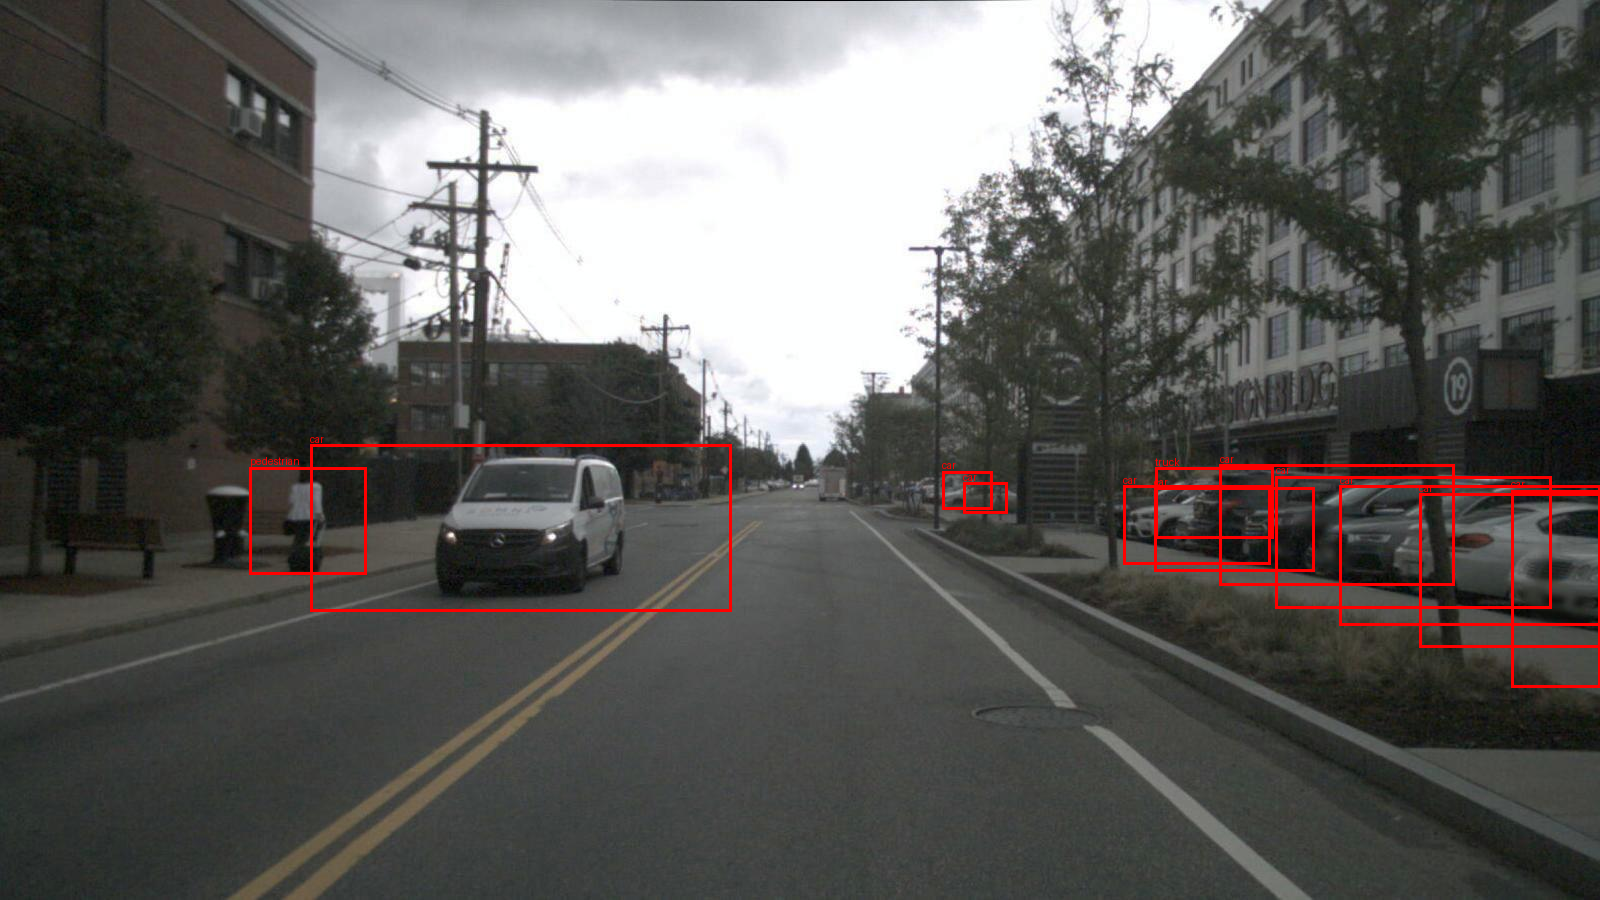

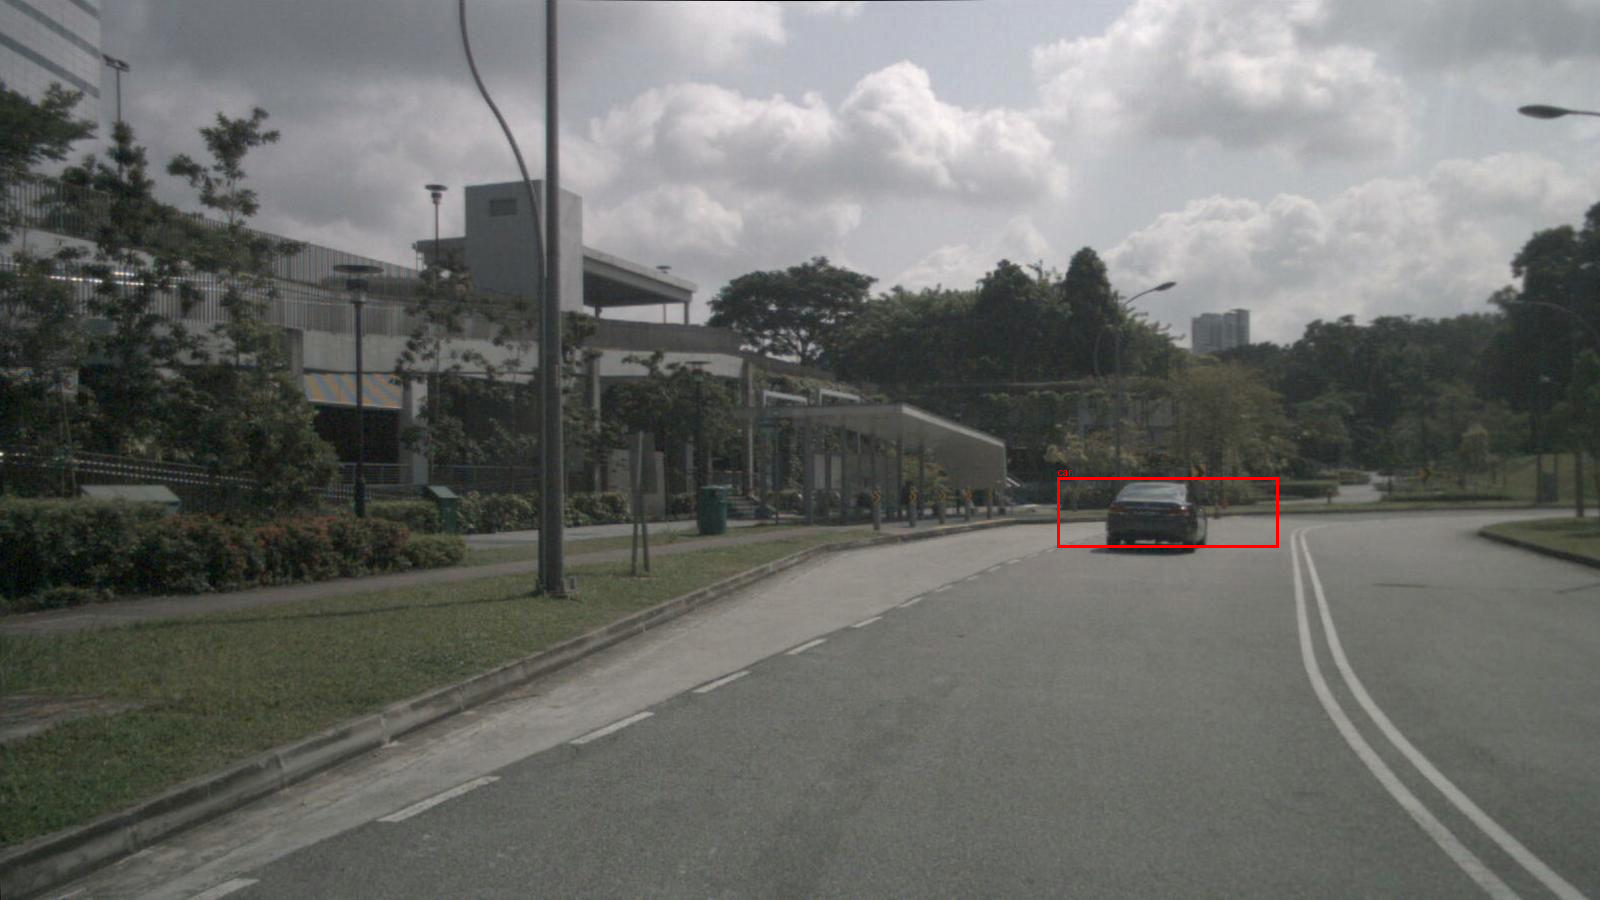

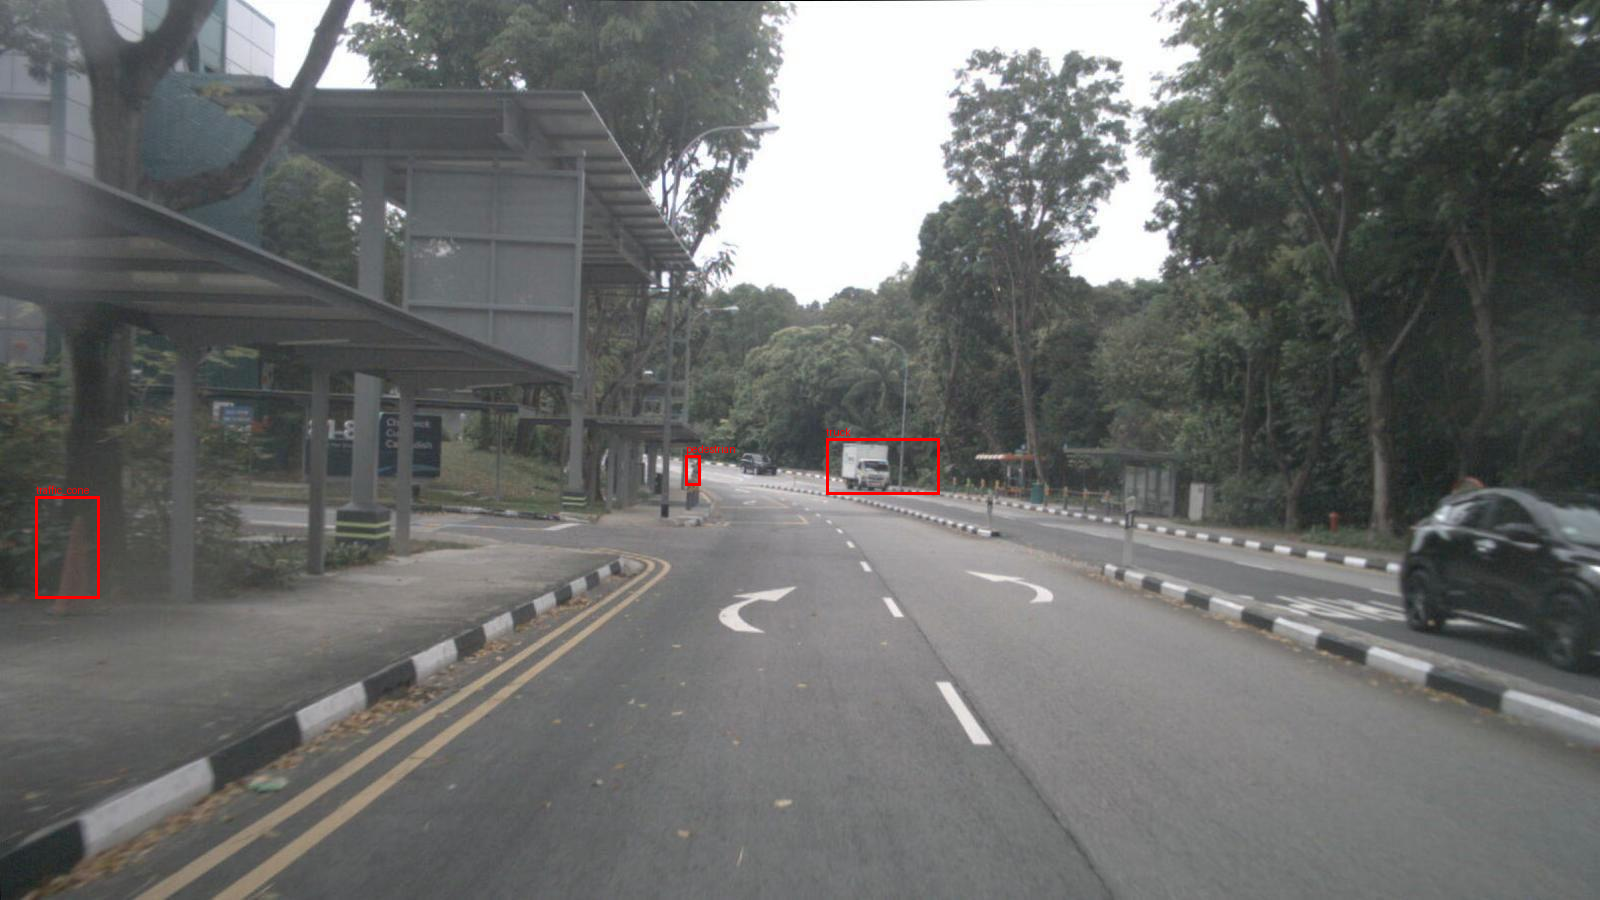

In [ ]:
from pathlib import Path
from collections import defaultdict
from IPython.display import display
from PIL import Image, ImageDraw
import json, random

VAL_JSON    = Path("nuscenes_coco/annotations/instances_val.json")
VAL_IMG_DIR = Path("nuscenes_coco/images/val")  
VAL_IMG_DIR_FALLBACK = Path("nuscenes_yolo/images/val")  

assert VAL_JSON.exists(), f"Missing COCO val JSON: {VAL_JSON}"
assert VAL_IMG_DIR.exists() or VAL_IMG_DIR_FALLBACK.exists(), "Val images folder not found."

with open(VAL_JSON, "r") as f:
    val_coco = json.load(f)

id_to_name = {c["id"]: c["name"] for c in val_coco["categories"]}

id_to_anns = defaultdict(list)
for a in val_coco["annotations"]:
    if "bbox" in a and a["bbox"] is not None:
        id_to_anns[a["image_id"]].append(a)

# Picking few images to visualize
images_val = val_coco["images"]
random.seed(42)
sample_images = random.sample(images_val, k=min(3, len(images_val)))

for im in sample_images:
    fname = Path(im["file_name"]).name
    img_path = VAL_IMG_DIR / fname
    if not img_path.exists():
        img_path = VAL_IMG_DIR_FALLBACK / fname
    assert img_path.exists(), f"Image not found for visualization: {img_path}"

    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)

    for a in id_to_anns[im["id"]]:
        x, y, w, h = a["bbox"]  # COCO xywh (pixels)
        draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
        label = id_to_name.get(a["category_id"], "?")
        ty = max(0, y - 12)
        draw.text((x, ty), label, fill="red")

    display(img)


## Training :

* Here we train all those edited models mentioned above
* Quick Setup overview: 20 epochs, default yolo training models AdamW(lr=0.000714, momentum=0.9) on approx 4400 images.

In [ ]:
# Training YOLOv8 models
from ultralytics import YOLO
import gc

# All are being trained for default model scale 'nano(n)'
MODEL_YAMLS = [
    "yolov8.yaml",
    "yolov8_P2.yaml",
    "yolov8_P2_repeat.yaml",
    "yolov8_P2_repeat_channels.yaml",
    "yolov8_P2_P1.yaml"
]
# Tune batches to your VRAM; these are conservative for ~8GB

EPOCHS = 20
IMG_SZ = 640
DEVICE = 0 if torch.cuda.is_available() else "cpu"

for cfg in MODEL_YAMLS:
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    run_name = f"nuscenes_{cfg}"
    model = YOLO(cfg) 
    model.train(
        data=str(DATA_YAML),
        epochs=EPOCHS,
        imgsz=IMG_SZ,
        batch=8,
        workers=0,            # Windows/WSL safe; raise if Linux desktop
        device=DEVICE,
        name=run_name,
        cache=False,
    )
print("Training jobs finished.")


WARNING no model scale passed. Assuming scale='n'.
Ultralytics 8.3.221  Python-3.11.14 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\manav\IA\nuscenes_yolo\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8_P2_P0.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=nuscenes_yolov8_P2_P0.yaml, nbs=64, nms=False, 

## Validation and Testing

* Focus here is on, testing all the trained models, and showcasing which performs best, that can be seen in DataFrame Printed at the bottom
* (Key Takeaway: Big Channels == Higher mAP)

In [ ]:
import pandas as pd
from pathlib import Path
from ultralytics import YOLO

def extract_metrics(res):
    m = getattr(res, "results_dict", None) or {}
    return {
        "mAP50-95":  m.get("metrics/mAP50-95(B)", m.get("metrics/mAP50-95", None)),
        "mAP50":     m.get("metrics/mAP50(B)",    m.get("metrics/mAP50",    None)),
        "precision": m.get("metrics/precision(B)",m.get("metrics/precision",None)),
        "recall":    m.get("metrics/recall(B)",   m.get("metrics/recall",   None)),
    }

rows = []
for cfg in MODEL_YAMLS:
    run_name = f"nuscenes_{cfg}"
    best = Path("C:/Users/manav/runs/detect") / run_name / "weights" / "best.pt"
    assert best.exists(), f"Missing best weights for {run_name}"
    model = YOLO(str(best))

    res_val  = model.val(data=str(DATA_YAML), split="val",  workers=0, device=DEVICE, plots=False)
    res_test = model.val(data=str(DATA_YAML), split="test", workers=0, device=DEVICE, plots=False)

    mv = extract_metrics(res_val)
    mt = extract_metrics(res_test)

    rows.append({
        "model": run_name,
        "val_mAP50-95":  mv["mAP50-95"], "val_mAP50":  mv["mAP50"],
        "val_precision": mv["precision"], "val_recall": mv["recall"],
        "test_mAP50-95": mt["mAP50-95"], "test_mAP50": mt["mAP50"],
        "test_precision":mt["precision"], "test_recall": mt["recall"],
    })

summary = pd.DataFrame(rows).sort_values("test_mAP50-95", ascending=False)
summary_path = BASE_DIR / "yolo_nuscenes_summary.csv"
summary.to_csv(summary_path, index=False)
summary


Ultralytics 8.3.221  Python-3.11.14 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 8188MiB)
YOLOv8 summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 199.353.0 MB/s, size: 120.5 KB)
val: Scanning C:\Users\manav\IA\nuscenes_yolo\labels\val.cache... 546 images, 18 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 546/546 548.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 35/35 4.9it/s 7.2s0.2s
                   all        546       5335      0.501      0.213      0.208     0.0918
                   car        459       2268      0.486      0.576      0.545      0.285
                 truck        270        475      0.395      0.177      0.198     0.0903
                   bus         82        108      0.389      0.315      0.308       0.16
               trailer         92        157      0.304     0.0955      0.101     0.0326
  constru

model  val_mAP50-95  val_mAP50  \
0                     nuscenes_yolov8.yaml      0.091821   0.208444   
3  nuscenes_yolov8_P2_repeat_channels.yaml      0.087876   0.197695   
4               nuscenes_yolov8_P2_P1.yaml      0.088821   0.198834   
2           nuscenes_yolov8_P2_repeat.yaml      0.063660   0.146879   
1                  nuscenes_yolov8_P2.yaml      0.060806   0.142846   

   val_precision  val_recall  test_mAP50-95  test_mAP50  test_precision  \
0       0.500803    0.213321       0.101052    0.224743        0.507280   
3       0.478116    0.227161       0.096673    0.217850        0.494276   
4       0.488610    0.229006       0.094227    0.208336        0.537164   
2       0.466731    0.190551       0.068597    0.159407        0.490401   
1       0.479889    0.180229       0.066834    0.154167        0.510531   

   test_recall  
0     0.247340  
3     0.254790  
4     0.230783  
2     0.203385  
1     0.191399

This is code for plotting a comparitive bar figure, it is displayed in the ReadMe.md

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = summary.copy()

def pick(candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"None of {candidates} found. Available: {list(df.columns)}")

COL_MODEL   = pick(["model", "Model", "name"])
COL_MAP5095 = pick(["test_mAP50-95", "mAP50-95", "test_map50_95", "map50_95", "map5095"])
COL_MAP50   = pick(["test_mAP50", "mAP50", "map50"])
COL_PREC    = pick(["test_precision", "precision", "P", "test_P"])
COL_REC     = pick(["test_recall", "recall", "R", "test_R"])

for c in [COL_MAP5095, COL_MAP50, COL_PREC, COL_REC]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[COL_MAP5095, COL_MAP50, COL_PREC, COL_REC])

x = df[COL_MODEL].astype(str).values

fig, axes = plt.subplots(2, 2, figsize=(12, 7))

def bar(ax, y, title, ylabel):
    ax.bar(x, y)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=15)
    # value labels
    for i, v in enumerate(y):
        try:
            ax.text(i, float(v), f"{float(v):.3f}", ha="center", va="bottom", fontsize=8)
        except Exception:
            pass

bar(axes[0,0], df[COL_MAP5095].values, "mAP@50-95 (test)", "mAP@50-95")
bar(axes[0,1], df[COL_MAP50].values,   "mAP@50 (test)",     "mAP@50")
bar(axes[1,0], df[COL_PREC].values,    "Precision (test)",  "Precision")
bar(axes[1,1], df[COL_REC].values,     "Recall (test)",     "Recall")

fig.suptitle("NuScenes subset — YOLOv8 (scratch from custom YAMLs)", y=0.98)
fig.tight_layout()
plt.show()

# Also save for scripts/headless runs
fig.savefig("nuscenes_yolo_metrics_grid.png", dpi=150)
print("Saved: nuscenes_yolo_metrics_grid.png")


<Figure size 1200x700 with 4 Axes>

Saved: nuscenes_yolo_metrics_grid.png
